In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data/train.csv")
df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("data/train.csv")

df.drop(columns=["casual", "registered"], inplace=True)

df["datetime"] = pd.to_datetime(df["datetime"])
df["hour"] = df["datetime"].dt.hour
df["day"] = df["datetime"].dt.day
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.weekday

df.drop(columns=["datetime"], inplace=True)

df = pd.get_dummies(df, columns=["season", "weather"], drop_first=False)

X = df.drop(columns=["count"])
y = df["count"]

y = np.log1p(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y.values.reshape(-1, 1), test_size=0.2, random_state=42
)

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)



In [21]:
X_train.T.shape

(18, 8708)

In [19]:
X_train.shape

(8708, 18)

### WIEGHTS AND BIAS INITIALIZATION

In [26]:
def he_init_weights(in_shape:int,out_shape:int):
    return np.random.randn(out_shape,in_shape)*np.sqrt(2.0/in_shape)

def bias_init(out_shape:int):
    return np.zeros((out_shape,1))

### RELU

In [34]:
def relu(output:float):
    return np.maximum(0,output)

def relu_derivative(Z):
    return (Z > 0).astype(float)

### LOSS FUNCTIONS

In [36]:
def MSE(y_pred,y_true):
    return np.mean(np.square(y_true-y_pred))

def dMSE(y_pred,y_true):
    return (2*(y_pred-y_true))/(y_true.shape[1])

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)             
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)     
    return 1 - (ss_res / ss_tot)


### MODEL WITH FORWARD AND BACKWARD PROPOGATION

In [35]:
class LinearModel:
    def __init__(self,input_shape:int,lr:float):
        self.lr = lr
        
        self.W_layer1 = he_init_weights(input_shape,128)
        self.B_layer1 = bias_init(128)
        
        self.W_layer2 =he_init_weights(128,64)
        self.B_layer2 = bias_init(64)
        
        self.W_output = he_init_weights(64,1)
        self.B_output = bias_init(1)

    def forward(self,X:np.ndarray):
        self.Z1 = np.matmul(self.W_layer1, X) + self.B_layer1
        self.A1 = relu(self.Z1)
    
        self.Z2 = np.matmul(self.W_layer2, self.A1) + self.B_layer2
        self.A2 = relu(self.Z2)
    
        self.Z3 = np.matmul(self.W_output, self.A2) + self.B_output
        return self.Z3

    def backward(self, X, Y_true, Y_pred):
        m = Y_true.shape[1]

        dZ3 = (2 / m) * (Y_pred - Y_true)      
        dW3 = np.dot(dZ3, self.A2.T)              
        dB3 = np.sum(dZ3, axis=1, keepdims=True) 
    

        dA2 = np.dot(self.W_output.T, dZ3)
        dZ2 = dA2 * relu_derivative(self.Z2)  
        dW2 = np.dot(dZ2, self.A1.T)                
        dB2 = np.sum(dZ2, axis=1, keepdims=True) 
    

        dA1 = np.dot(self.W_layer2.T, dZ2)     
        dZ1 = dA1 * relu_derivative(self.Z1)     
        dW1 = np.dot(dZ1, X.T)             
        dB1 = np.sum(dZ1, axis=1, keepdims=True) 
    

        self.W_output -= self.lr * dW3
        self.B_output -= self.lr * dB3
    
        self.W_layer2 -= self.lr * dW2
        self.B_layer2 -= self.lr * dB2
    
        self.W_layer1 -= self.lr * dW1
        self.B_layer1 -= self.lr * dB1


In [37]:
X_train.shape[1]

18

### FINAL TRAINING LOOP

In [48]:
from tqdm.auto import tqdm


def train(epochs:int,learning_rate:float):
    
    train_loss = []
    test_loss = []
    
    train_r2_scores = []
    test_r2_scores = []
    
    model = LinearModel(X_train.shape[1],learning_rate)
    
    for epoch in tqdm(range(epochs)):
        y_pred_train = model.forward(X_train.T)
        loss_train = MSE(y_pred_train, y_train.T)
        
        model.backward(X_train.T, y_train.T, y_pred_train)
    
        y_pred_test = model.forward(X_test.T)
        loss_test = MSE(y_pred_test, y_test.T)
    
        r2_train = r2_score(y_train.T, y_pred_train)
        r2_test = r2_score(y_test.T, y_pred_test)
    
    
        
        train_loss.append(loss_train)
        test_loss.append(loss_test)
    
        train_r2_scores.append(r2_train)
        test_r2_scores.append(r2_test)
        
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Train loss : {loss_train:.4f} Train R2 score : {r2_train:.4f} | Test loss : {loss_test:.4f} Test R2 score : {r2_test:.4f}")
    
    
    result = {
        "Model": model.__class__.__name__,
        "train loss": np.mean(train_loss),
        "test loss": np.mean(test_loss),
        "train R2 score": np.mean(train_r2_scores),
        "test R2 score": np.mean(test_r2_scores)
    }
    return train_loss,test_loss,train_r2_scores,test_r2_scores,result

### TRAINING THE MODEL FOR 1000 EPOCHS WITH LEARNING RATE OF 0.001

In [49]:
train_loss,test_loss,train_r2_scores,test_r2_scores,result = train(1000,0.001)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 0 | Train loss : 24.7615 Train R2 score : -11.3580 | Test loss : 22.1633 Test R2 score : -9.7667
Epoch 100 | Train loss : 1.7274 Train R2 score : 0.1379 | Test loss : 1.7469 Test R2 score : 0.1514
Epoch 200 | Train loss : 1.4820 Train R2 score : 0.2604 | Test loss : 1.4936 Test R2 score : 0.2744
Epoch 300 | Train loss : 1.3490 Train R2 score : 0.3268 | Test loss : 1.3580 Test R2 score : 0.3403
Epoch 400 | Train loss : 1.2698 Train R2 score : 0.3662 | Test loss : 1.2776 Test R2 score : 0.3793
Epoch 500 | Train loss : 1.2200 Train R2 score : 0.3911 | Test loss : 1.2270 Test R2 score : 0.4039
Epoch 600 | Train loss : 1.1873 Train R2 score : 0.4074 | Test loss : 1.1940 Test R2 score : 0.4200
Epoch 700 | Train loss : 1.1644 Train R2 score : 0.4189 | Test loss : 1.1713 Test R2 score : 0.4310
Epoch 800 | Train loss : 1.1478 Train R2 score : 0.4272 | Test loss : 1.1551 Test R2 score : 0.4389
Epoch 900 | Train loss : 1.1353 Train R2 score : 0.4334 | Test loss : 1.1427 Test R2 score : 0.44

In [51]:
result

{'Model': 'LinearModel',
 'train loss': 1.5146088618990365,
 'test loss': 1.5001047697304883,
 'train R2 score': 0.24408304285751792,
 'test R2 score': 0.2712650862222426}

### PLOTTING THE CURVES

In [56]:
from typing import List
import matplotlib.pyplot as plt
def plot(train_loss:List[float],test_loss:List[float],train_r2:List[float],test_r2:List[float]):
    
    fig = plt.figure(figsize=(15,7))
    epochs = [x for x in range(0,1000)]

    ax1 = plt.subplot(2,2,1)
    ax1.plot(epochs,train_loss)
    ax1.set_title("Train Loss")

    ax2 = plt.subplot(2,2,2)
    ax2.plot(epochs,train_r2)
    ax2.set_title("Train R2 Score")
    
    ax3 = plt.subplot(2,2,3)
    ax3.plot(epochs,test_loss)
    ax3.set_title("Test Loss")
    
    ax4 = plt.subplot(2,2,4)
    ax4.plot(epochs,test_r2)
    ax4.set_title("Test R2 Score")

    plt.suptitle("Result:")

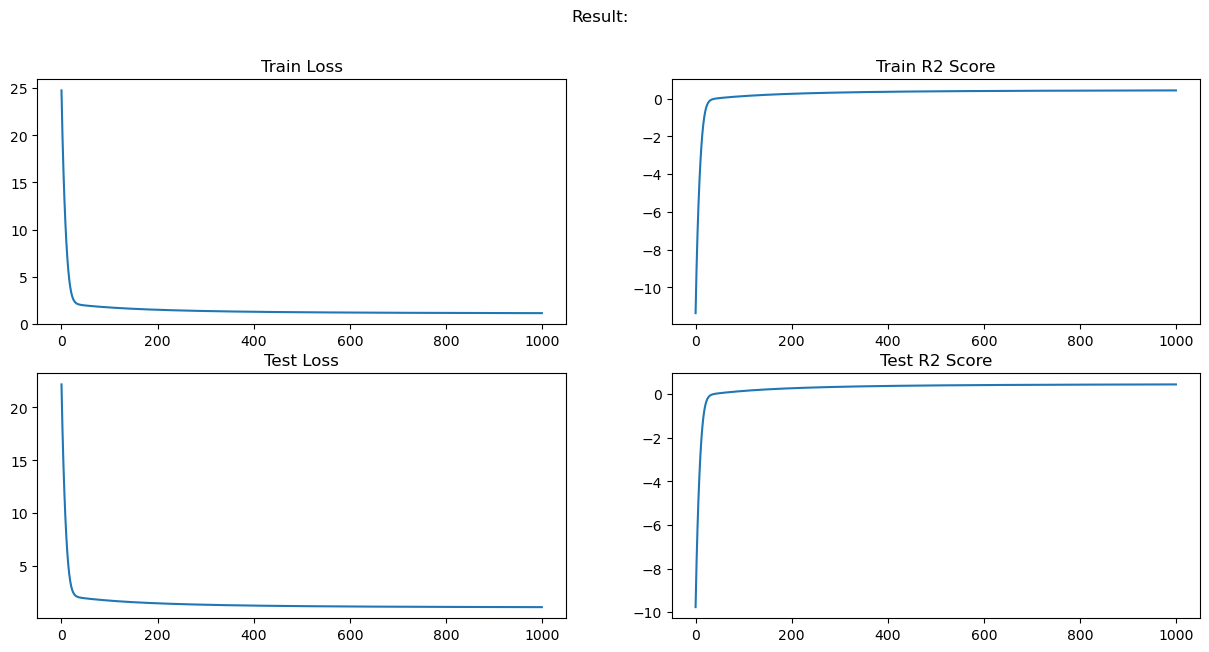

In [57]:
plot(train_loss,test_loss,train_r2_scores,test_r2_scores)

In [60]:
train_r2_scores[-1]

0.4381995673773097

In [61]:
test_r2_scores[-1]

0.44959871080204394